# 08. SHAP 可解釋性分析

## 📖 實驗目標

使用 **SHAP (SHapley Additive exPlanations)** 分析模型的特徵重要性與預測解釋。

### 為什麼需要 SHAP？

1. **理論基礎扎實**：基於賽局理論的 Shapley 值，具有數學保證
2. **一致性**：滿足局部準確性、缺失性、一致性等特性
3. **可視化豐富**：蜂群圖、瀑布圖、依賴圖等多種解釋方式
4. **醫學應用價值**：能解釋「為什麼這個病人被預測為高風險」

### 分析對象

根據前面實驗結果，選擇各疾病最佳模型：
- **高血壓**：XGBoost（AUC=0.795，可解釋性佳）
- **高血糖**：LR（AUC=0.931）+ XGBoost（對照）
- **高血脂**：LR（AUC=0.888）+ XGBoost（對照）

---

## 📋 實驗流程

1. 載入資料與訓練模型
2. SHAP 值計算
3. 全域特徵重要性（Summary Plot）
4. 蜂群圖（Beeswarm Plot）
5. 特徵依賴圖（Dependence Plot）
6. 單一樣本解釋（Waterfall Plot）
7. 三種疾病的特徵重要性比較
8. 結論與臨床意義

## 1. 安裝與載入套件

In [1]:
# 安裝 SHAP 套件（如果尚未安裝）
import sys
!{sys.executable} -m pip install shap

     -------------------------------------- 462.1/462.1 kB 1.6 MB/s eta 0:00:00


In [2]:
# 基礎套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 機器學習套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# SHAP
import shap

# 設定
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 初始化 SHAP 的 JavaScript 視覺化（for notebook）
shap.initjs()

print(f"✅ 套件載入完成")
print(f"SHAP 版本: {shap.__version__}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


✅ 套件載入完成
SHAP 版本: 0.42.1


## 2. 載入資料

In [3]:
# 載入資料
df = pd.read_csv('../../data/processed/SUA_CVDs_wide_format.csv')

print(f"✅ 資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 人, {df.shape[1]} 個欄位")

✅ 資料載入成功！
資料形狀: 6,056 人, 107 個欄位


In [4]:
# 定義特徵組
demographic_features = ['sex', 'Age']
biomarker_names = ['FBG', 'TC', 'Cr', 'UA', 'GFR', 'BMI', 'SBP', 'DBP']
t1_features = [f'{name}_T1' for name in biomarker_names]
t2_features = [f'{name}_T2' for name in biomarker_names]
delta1_features = [f'Delta1_{name}' for name in biomarker_names]

# 完整特徵集
X_columns = demographic_features + t1_features + t2_features + delta1_features
X = df[X_columns]

# 目標變數（轉換為 0/1）
y_hypertension = (df['hypertension_T3'] == 2).astype(int)
y_hyperglycemia = (df['hyperglycemia_T3'] == 2).astype(int)
y_dyslipidemia = (df['dyslipidemia_T3'] == 2).astype(int)

# 特徵中文名稱對照（用於視覺化）
feature_names_chinese = {
    'sex': '性別',
    'Age': '年齡',
    'FBG_T1': '空腹血糖_T1', 'FBG_T2': '空腹血糖_T2', 'Delta1_FBG': 'Δ空腹血糖',
    'TC_T1': '總膽固醇_T1', 'TC_T2': '總膽固醇_T2', 'Delta1_TC': 'Δ總膽固醇',
    'Cr_T1': '肌酸酐_T1', 'Cr_T2': '肌酸酐_T2', 'Delta1_Cr': 'Δ肌酸酐',
    'UA_T1': '尿酸_T1', 'UA_T2': '尿酸_T2', 'Delta1_UA': 'Δ尿酸',
    'GFR_T1': '腎功能_T1', 'GFR_T2': '腎功能_T2', 'Delta1_GFR': 'Δ腎功能',
    'BMI_T1': 'BMI_T1', 'BMI_T2': 'BMI_T2', 'Delta1_BMI': 'ΔBMI',
    'SBP_T1': '收縮壓_T1', 'SBP_T2': '收縮壓_T2', 'Delta1_SBP': 'Δ收縮壓',
    'DBP_T1': '舒張壓_T1', 'DBP_T2': '舒張壓_T2', 'Delta1_DBP': 'Δ舒張壓'
}

print(f"特徵數: {len(X_columns)} 個")
print(f"\n目標變數分佈:")
print(f"  高血壓患病率: {y_hypertension.mean():.2%}")
print(f"  高血糖患病率: {y_hyperglycemia.mean():.2%}")
print(f"  高血脂患病率: {y_dyslipidemia.mean():.2%}")

特徵數: 26 個

目標變數分佈:
  高血壓患病率: 16.68%
  高血糖患病率: 5.53%
  高血脂患病率: 5.96%


## 3. 資料分割與標準化

In [5]:
# 資料分割
X_train, X_test, y_train_hp, y_test_hp = train_test_split(
    X, y_hypertension, test_size=0.2, random_state=42, stratify=y_hypertension
)

# 同步分割其他目標變數
_, _, y_train_hg, y_test_hg = train_test_split(
    X, y_hyperglycemia, test_size=0.2, random_state=42, stratify=y_hypertension
)
_, _, y_train_dl, y_test_dl = train_test_split(
    X, y_dyslipidemia, test_size=0.2, random_state=42, stratify=y_hypertension
)

# 標準化（SHAP 分析時使用原始特徵值更容易解釋，但訓練需要標準化）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉回 DataFrame（保留欄位名稱，方便 SHAP 視覺化）
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_columns, index=X_test.index)

print(f"✅ 資料準備完成")
print(f"訓練集: {X_train_scaled.shape[0]} 人")
print(f"測試集: {X_test_scaled.shape[0]} 人")

✅ 資料準備完成
訓練集: 4844 人
測試集: 1212 人


## 4. 訓練模型

訓練 XGBoost 和 LR 模型，用於 SHAP 分析。

In [6]:
# 計算 scale_pos_weight
def calc_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# 訓練 XGBoost 模型（三種疾病）
xgb_models = {}
diseases = ['高血壓', '高血糖', '高血脂']
y_trains = [y_train_hp, y_train_hg, y_train_dl]
y_tests = [y_test_hp, y_test_hg, y_test_dl]

print("="*60)
print("訓練 XGBoost 模型")
print("="*60)

for disease, y_train, y_test in zip(diseases, y_trains, y_tests):
    spw = calc_scale_pos_weight(y_train)
    
    model = XGBClassifier(
        scale_pos_weight=spw,
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    xgb_models[disease] = model
    print(f"{disease}: AUC = {auc:.3f}")

print("\n✅ XGBoost 模型訓練完成")

訓練 XGBoost 模型
高血壓: AUC = 0.795
高血糖: AUC = 0.903
高血脂: AUC = 0.886

✅ XGBoost 模型訓練完成


In [7]:
# 訓練 Logistic Regression 模型（三種疾病）
lr_models = {}

print("="*60)
print("訓練 Logistic Regression 模型")
print("="*60)

for disease, y_train, y_test in zip(diseases, y_trains, y_tests):
    model = LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    )
    model.fit(X_train_scaled, y_train)
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    lr_models[disease] = model
    print(f"{disease}: AUC = {auc:.3f}")

print("\n✅ Logistic Regression 模型訓練完成")

訓練 Logistic Regression 模型
高血壓: AUC = 0.749
高血糖: AUC = 0.931
高血脂: AUC = 0.888

✅ Logistic Regression 模型訓練完成


## 5. SHAP 分析 - 高血壓（XGBoost）

高血壓是 XGBoost 表現最好的疾病，先從這裡開始分析。

In [8]:
# 計算 SHAP 值（使用 TreeExplainer，對樹模型最高效）
print("計算高血壓 XGBoost 模型的 SHAP 值...")

explainer_hp = shap.TreeExplainer(xgb_models['高血壓'])
shap_values_hp = explainer_hp.shap_values(X_test_scaled_df)

print(f"✅ SHAP 值計算完成")
print(f"SHAP values shape: {shap_values_hp.shape}")

計算高血壓 XGBoost 模型的 SHAP 值...
✅ SHAP 值計算完成
SHAP values shape: (1212, 26)


### 5.1 Summary Plot（全域特徵重要性）

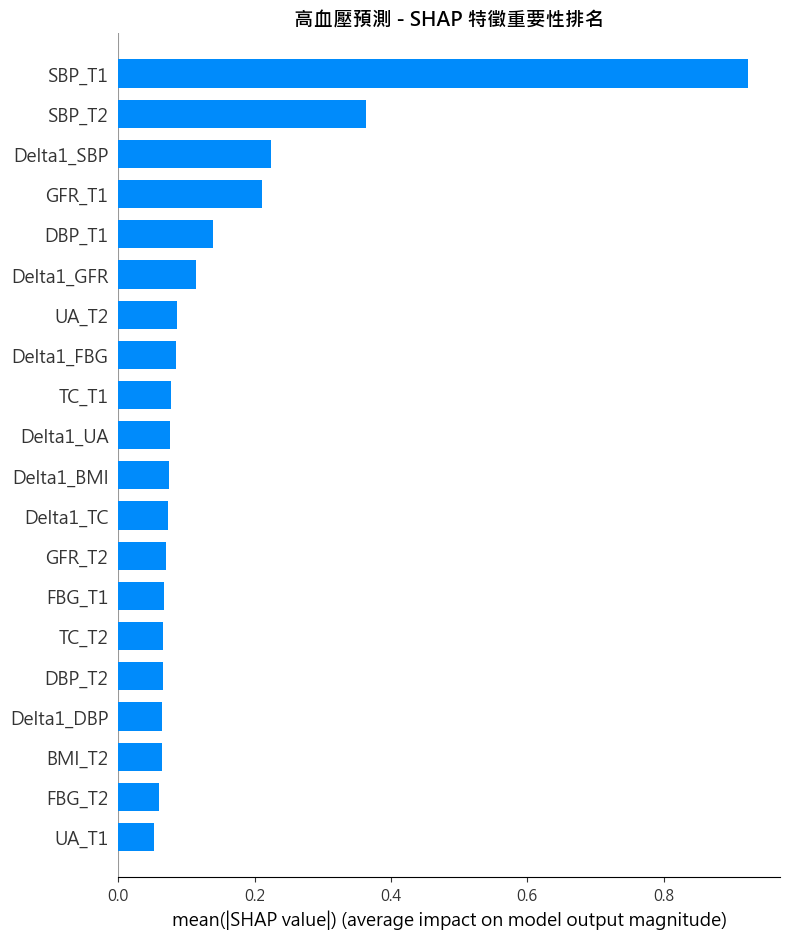

✅ 已儲存: docs/experiments/shap_hypertension_importance.png


In [9]:
# Summary Plot - Bar（特徵重要性排名）
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_hp, X_test_scaled_df, plot_type="bar", show=False)
plt.title('高血壓預測 - SHAP 特徵重要性排名', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_hypertension_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_hypertension_importance.png")

### 5.2 Beeswarm Plot（蜂群圖）

蜂群圖可以同時顯示：
- 特徵重要性（Y軸排序）
- 特徵值的影響方向（X軸：正/負 SHAP 值）
- 特徵值的大小（顏色）

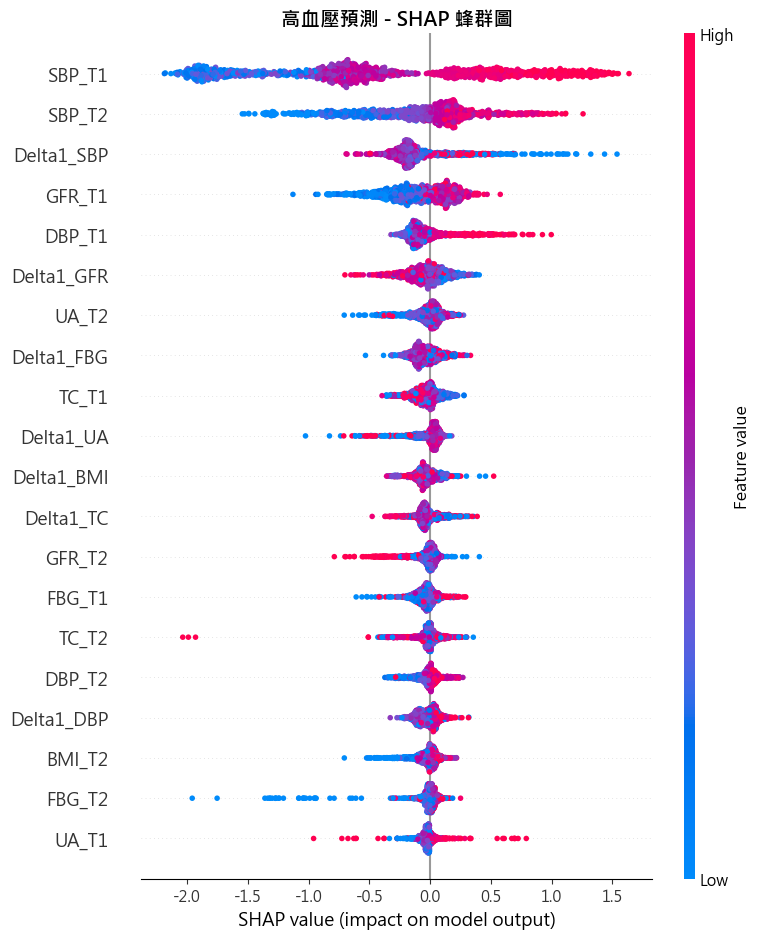

✅ 已儲存: docs/experiments/shap_hypertension_beeswarm.png


In [10]:
# Beeswarm Plot（蜂群圖）
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_hp, X_test_scaled_df, show=False)
plt.title('高血壓預測 - SHAP 蜂群圖', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_hypertension_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_hypertension_beeswarm.png")

### 5.3 Dependence Plot（依賴圖）

分析單一特徵與 SHAP 值的關係，揭示非線性效應。

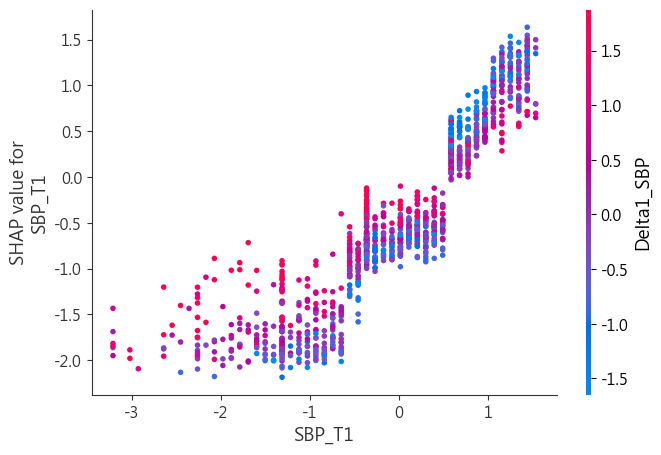

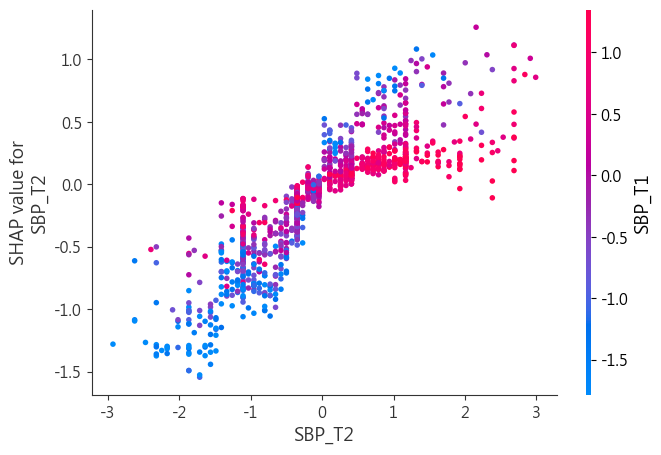

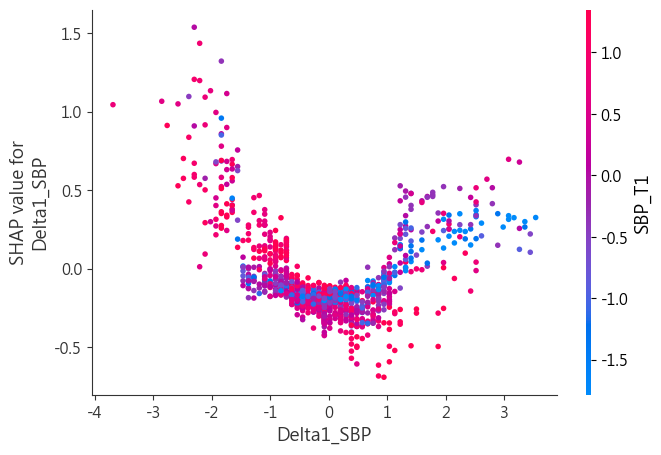

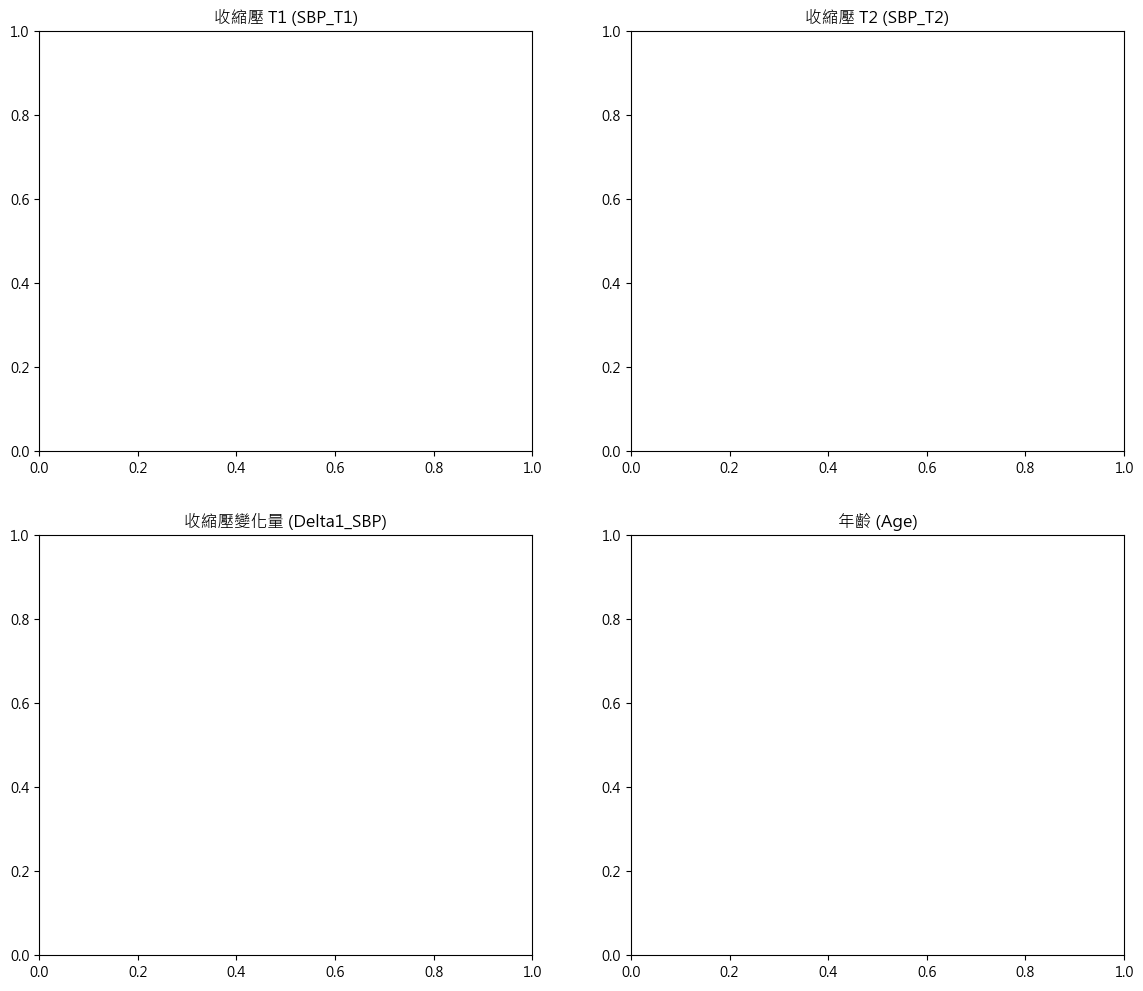

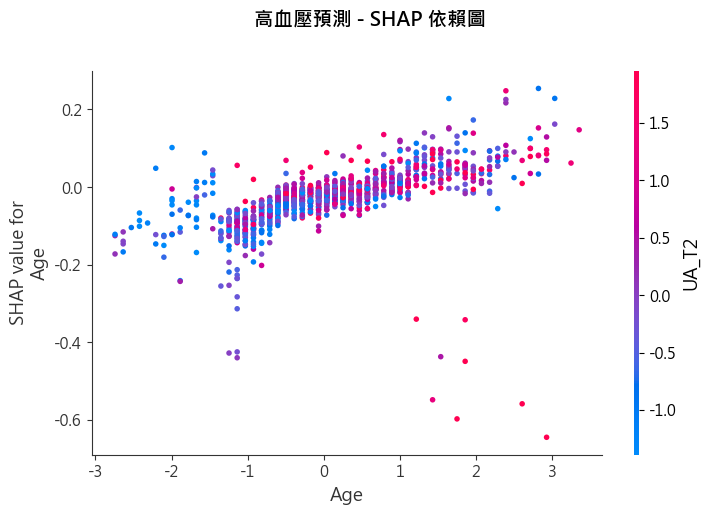

✅ 已儲存: docs/experiments/shap_hypertension_dependence.png


In [11]:
# 分析最重要的特徵：SBP_T1（收縮壓）
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# SBP_T1
plt.sca(axes[0, 0])
shap.dependence_plot('SBP_T1', shap_values_hp, X_test_scaled_df, show=False)
axes[0, 0].set_title('收縮壓 T1 (SBP_T1)', fontsize=12)

# SBP_T2
plt.sca(axes[0, 1])
shap.dependence_plot('SBP_T2', shap_values_hp, X_test_scaled_df, show=False)
axes[0, 1].set_title('收縮壓 T2 (SBP_T2)', fontsize=12)

# Delta1_SBP
plt.sca(axes[1, 0])
shap.dependence_plot('Delta1_SBP', shap_values_hp, X_test_scaled_df, show=False)
axes[1, 0].set_title('收縮壓變化量 (Delta1_SBP)', fontsize=12)

# Age
plt.sca(axes[1, 1])
shap.dependence_plot('Age', shap_values_hp, X_test_scaled_df, show=False)
axes[1, 1].set_title('年齡 (Age)', fontsize=12)

plt.suptitle('高血壓預測 - SHAP 依賴圖', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_hypertension_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_hypertension_dependence.png")

### 5.4 Waterfall Plot（單一樣本解釋）

解釋模型對單一病人的預測邏輯。

In [12]:
# 找一個高風險和低風險的樣本
y_pred_proba_hp = xgb_models['高血壓'].predict_proba(X_test_scaled)[:, 1]

# 高風險樣本（預測機率最高的）
high_risk_idx = np.argmax(y_pred_proba_hp)
# 低風險樣本（預測機率最低的）
low_risk_idx = np.argmin(y_pred_proba_hp)

print(f"高風險樣本索引: {high_risk_idx}, 預測機率: {y_pred_proba_hp[high_risk_idx]:.3f}")
print(f"低風險樣本索引: {low_risk_idx}, 預測機率: {y_pred_proba_hp[low_risk_idx]:.3f}")

高風險樣本索引: 1057, 預測機率: 0.959
低風險樣本索引: 115, 預測機率: 0.005


In [ ]:
# 高風險樣本的 Waterfall Plot
# 使用原始數據值（非標準化）來顯示特徵值
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values_hp[high_risk_idx],
    base_values=explainer_hp.expected_value,
    data=X_test.iloc[high_risk_idx].values,  # 使用原始數據
    feature_names=X_columns
), show=False)
plt.title(f'高血壓高風險樣本解釋 (預測機率={y_pred_proba_hp[high_risk_idx]:.3f})', fontsize=12)
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_hypertension_waterfall_high.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_hypertension_waterfall_high.png")

In [ ]:
# 低風險樣本的 Waterfall Plot
# 使用原始數據值（非標準化）來顯示特徵值
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values_hp[low_risk_idx],
    base_values=explainer_hp.expected_value,
    data=X_test.iloc[low_risk_idx].values,  # 使用原始數據
    feature_names=X_columns
), show=False)
plt.title(f'高血壓低風險樣本解釋 (預測機率={y_pred_proba_hp[low_risk_idx]:.3f})', fontsize=12)
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_hypertension_waterfall_low.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_hypertension_waterfall_low.png")

## 6. SHAP 分析 - 高血糖（XGBoost）

In [15]:
# 計算高血糖 SHAP 值
print("計算高血糖 XGBoost 模型的 SHAP 值...")

explainer_hg = shap.TreeExplainer(xgb_models['高血糖'])
shap_values_hg = explainer_hg.shap_values(X_test_scaled_df)

print(f"✅ SHAP 值計算完成")

計算高血糖 XGBoost 模型的 SHAP 值...
✅ SHAP 值計算完成


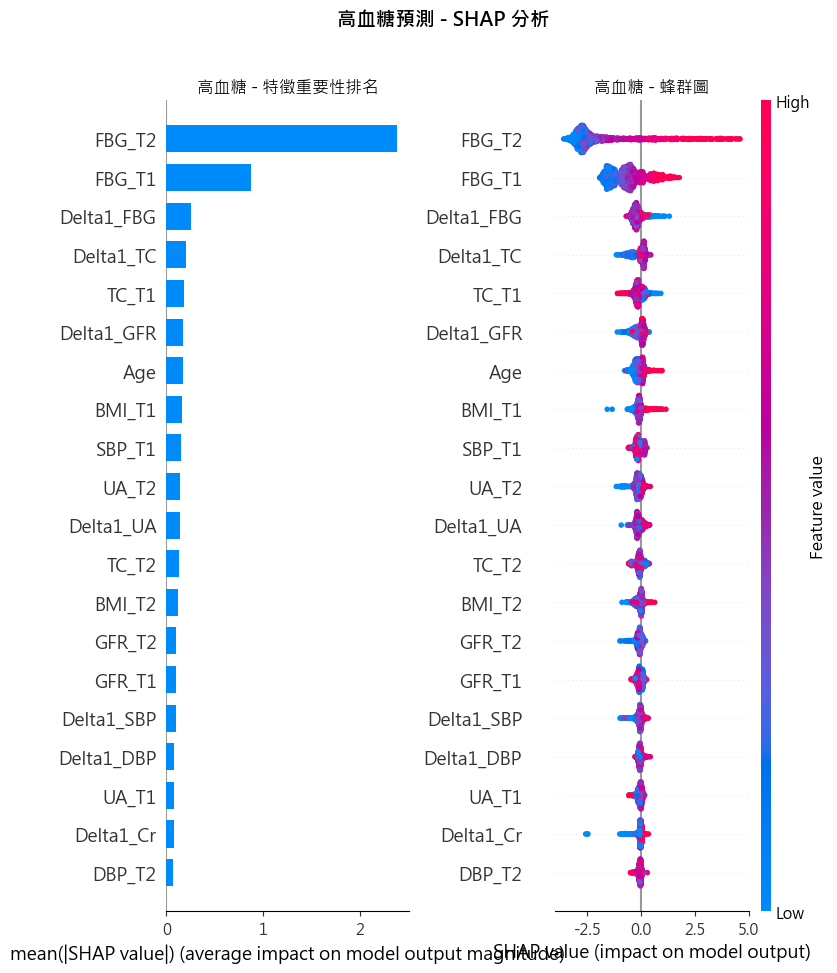

✅ 已儲存: docs/experiments/shap_hyperglycemia_summary.png


In [16]:
# 高血糖 Summary Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
plt.sca(axes[0])
shap.summary_plot(shap_values_hg, X_test_scaled_df, plot_type="bar", show=False)
axes[0].set_title('高血糖 - 特徵重要性排名', fontsize=12)

# Beeswarm plot
plt.sca(axes[1])
shap.summary_plot(shap_values_hg, X_test_scaled_df, show=False)
axes[1].set_title('高血糖 - 蜂群圖', fontsize=12)

plt.suptitle('高血糖預測 - SHAP 分析', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_hyperglycemia_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_hyperglycemia_summary.png")

## 7. SHAP 分析 - 高血脂（XGBoost）

In [17]:
# 計算高血脂 SHAP 值
print("計算高血脂 XGBoost 模型的 SHAP 值...")

explainer_dl = shap.TreeExplainer(xgb_models['高血脂'])
shap_values_dl = explainer_dl.shap_values(X_test_scaled_df)

print(f"✅ SHAP 值計算完成")

計算高血脂 XGBoost 模型的 SHAP 值...
✅ SHAP 值計算完成


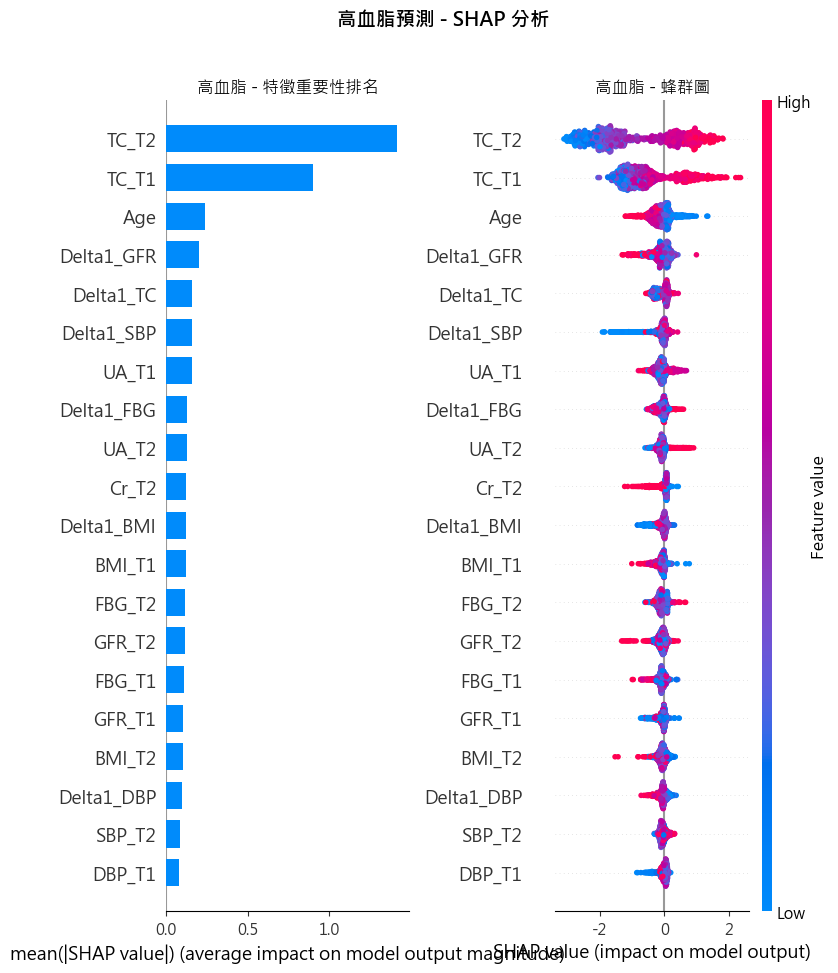

✅ 已儲存: docs/experiments/shap_dyslipidemia_summary.png


In [18]:
# 高血脂 Summary Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
plt.sca(axes[0])
shap.summary_plot(shap_values_dl, X_test_scaled_df, plot_type="bar", show=False)
axes[0].set_title('高血脂 - 特徵重要性排名', fontsize=12)

# Beeswarm plot
plt.sca(axes[1])
shap.summary_plot(shap_values_dl, X_test_scaled_df, show=False)
axes[1].set_title('高血脂 - 蜂群圖', fontsize=12)

plt.suptitle('高血脂預測 - SHAP 分析', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../docs/experiments/shap_dyslipidemia_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_dyslipidemia_summary.png")

## 8. 三種疾病特徵重要性比較

In [19]:
# 計算各疾病的平均 |SHAP| 值
importance_hp = pd.DataFrame({
    '特徵': X_columns,
    '高血壓': np.abs(shap_values_hp).mean(axis=0)
})

importance_hg = pd.DataFrame({
    '特徵': X_columns,
    '高血糖': np.abs(shap_values_hg).mean(axis=0)
})

importance_dl = pd.DataFrame({
    '特徵': X_columns,
    '高血脂': np.abs(shap_values_dl).mean(axis=0)
})

# 合併
importance_all = importance_hp.merge(importance_hg, on='特徵').merge(importance_dl, on='特徵')

# 按高血壓重要性排序
importance_all = importance_all.sort_values('高血壓', ascending=False)

print("="*80)
print("三種疾病 SHAP 特徵重要性比較（Top 15）")
print("="*80)
print(importance_all.head(15).to_string(index=False))

三種疾病 SHAP 特徵重要性比較（Top 15）
        特徵      高血壓      高血糖      高血脂
    SBP_T1 0.924370 0.149578 0.057844
    SBP_T2 0.363366 0.057419 0.085107
Delta1_SBP 0.224457 0.101543 0.160236
    GFR_T1 0.210483 0.103764 0.102256
    DBP_T1 0.138933 0.066010 0.077127
Delta1_GFR 0.113736 0.172474 0.202257
     UA_T2 0.086273 0.146711 0.126446
Delta1_FBG 0.084926 0.253766 0.129591
     TC_T1 0.077932 0.181270 0.899890
 Delta1_UA 0.075975 0.146119 0.062090
Delta1_BMI 0.075013 0.053456 0.123848
 Delta1_TC 0.073413 0.203975 0.160938
    GFR_T2 0.069494 0.105561 0.114146
    FBG_T1 0.067759 0.874945 0.112713
     TC_T2 0.066380 0.133496 1.419890


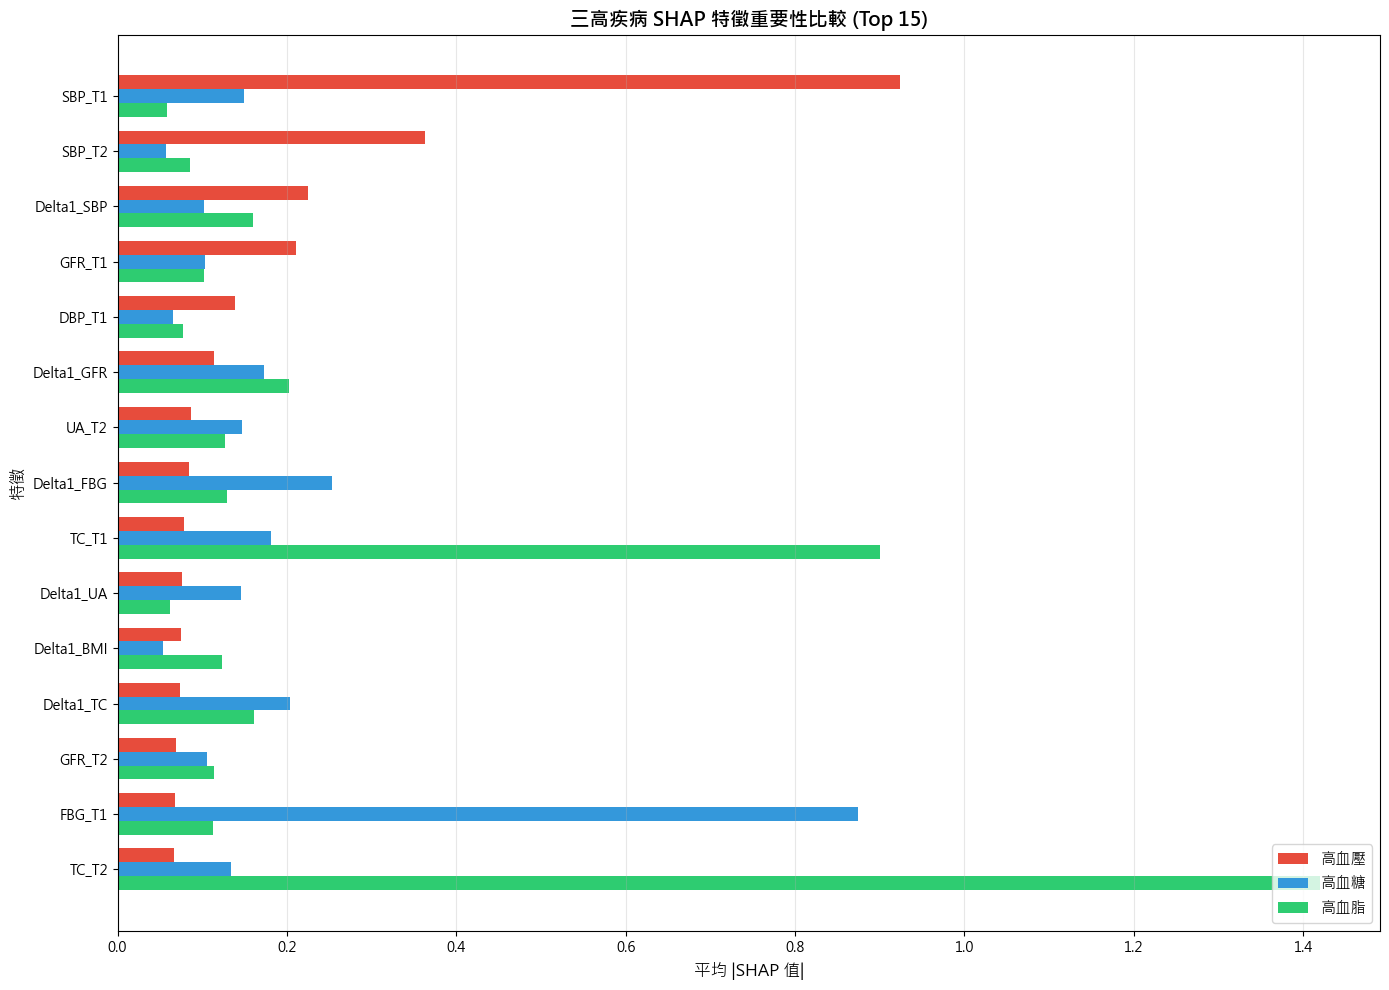

✅ 已儲存: docs/experiments/shap_comparison_all_diseases.png


In [20]:
# 視覺化比較
fig, ax = plt.subplots(figsize=(14, 10))

top_n = 15
importance_top = importance_all.head(top_n)

x = np.arange(top_n)
width = 0.25

bars1 = ax.barh(x - width, importance_top['高血壓'], width, label='高血壓', color='#e74c3c')
bars2 = ax.barh(x, importance_top['高血糖'], width, label='高血糖', color='#3498db')
bars3 = ax.barh(x + width, importance_top['高血脂'], width, label='高血脂', color='#2ecc71')

ax.set_xlabel('平均 |SHAP 值|', fontsize=12)
ax.set_ylabel('特徵', fontsize=12)
ax.set_title('三高疾病 SHAP 特徵重要性比較 (Top 15)', fontsize=14, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(importance_top['特徵'])
ax.legend(loc='lower right', fontsize=11)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../../docs/experiments/shap_comparison_all_diseases.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_comparison_all_diseases.png")

## 9. 特徵類別分析（T1 vs T2 vs Δ）

In [21]:
# 將特徵分類
def categorize_feature(name):
    if name in ['sex', 'Age']:
        return '人口統計'
    elif name.endswith('_T1'):
        return 'T1 特徵'
    elif name.endswith('_T2'):
        return 'T2 特徵'
    elif name.startswith('Delta1_'):
        return 'Δ 變化量'
    return '其他'

importance_all['類別'] = importance_all['特徵'].apply(categorize_feature)

# 按類別彙總
category_importance = importance_all.groupby('類別')[['高血壓', '高血糖', '高血脂']].sum()

print("="*80)
print("各特徵類別的總 SHAP 重要性")
print("="*80)
print(category_importance)

各特徵類別的總 SHAP 重要性
            高血壓       高血糖       高血脂
類別                                 
T1 特徵  1.523921  1.645148  1.571869
T2 特徵  0.786630  3.074891  2.155999
Δ 變化量  0.728962  1.086362  0.978817
人口統計   0.062669  0.178335  0.252189


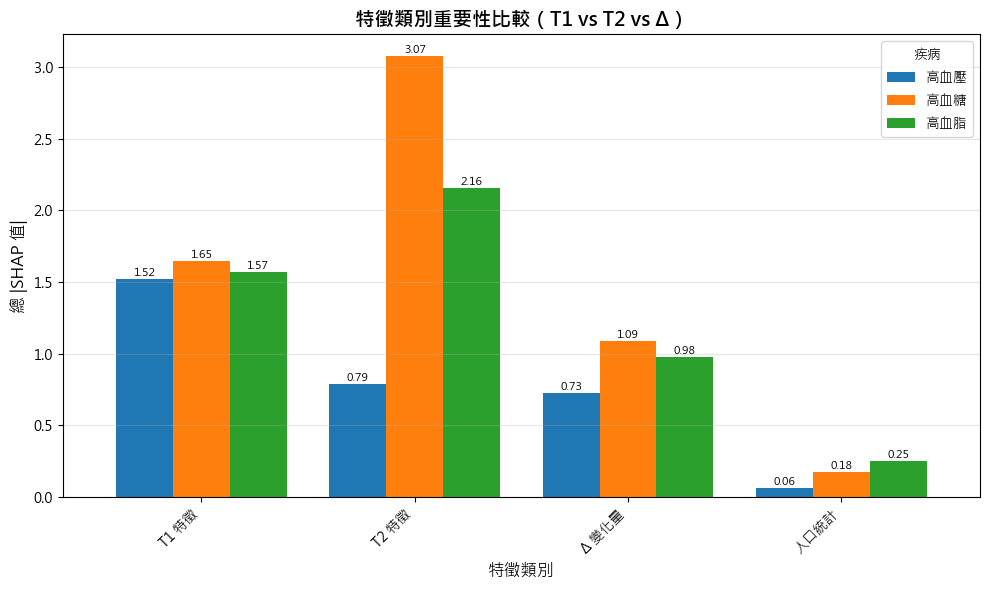

✅ 已儲存: docs/experiments/shap_category_importance.png


In [22]:
# 視覺化特徵類別重要性
fig, ax = plt.subplots(figsize=(10, 6))

category_importance.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('特徵類別', fontsize=12)
ax.set_ylabel('總 |SHAP 值|', fontsize=12)
ax.set_title('特徵類別重要性比較（T1 vs T2 vs Δ）', fontsize=14, fontweight='bold')
ax.legend(title='疾病', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# 添加數值標籤
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.savefig('../../docs/experiments/shap_category_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已儲存: docs/experiments/shap_category_importance.png")

## 10. 結論與臨床意義

In [23]:
# 輸出完整的特徵重要性表格
print("="*100)
print("完整 SHAP 特徵重要性表格")
print("="*100)

# 計算每個疾病的排名
importance_all['高血壓排名'] = importance_all['高血壓'].rank(ascending=False).astype(int)
importance_all['高血糖排名'] = importance_all['高血糖'].rank(ascending=False).astype(int)
importance_all['高血脂排名'] = importance_all['高血脂'].rank(ascending=False).astype(int)

# 格式化輸出
output_df = importance_all[['特徵', '類別', '高血壓', '高血壓排名', '高血糖', '高血糖排名', '高血脂', '高血脂排名']]
output_df = output_df.sort_values('高血壓', ascending=False)

print(output_df.to_string(index=False))

完整 SHAP 特徵重要性表格
        特徵    類別      高血壓  高血壓排名      高血糖  高血糖排名      高血脂  高血脂排名
    SBP_T1 T1 特徵 0.924370      1 0.149578      9 0.057844     23
    SBP_T2 T2 特徵 0.363366      2 0.057419     22 0.085107     19
Delta1_SBP Δ 變化量 0.224457      3 0.101543     16 0.160236      6
    GFR_T1 T1 特徵 0.210483      4 0.103764     15 0.102256     16
    DBP_T1 T1 特徵 0.138933      5 0.066010     21 0.077127     20
Delta1_GFR Δ 變化量 0.113736      6 0.172474      6 0.202257      4
     UA_T2 T2 特徵 0.086273      7 0.146711     10 0.126446      9
Delta1_FBG Δ 變化量 0.084926      8 0.253766      3 0.129591      8
     TC_T1 T1 特徵 0.077932      9 0.181270      5 0.899890      2
 Delta1_UA Δ 變化量 0.075975     10 0.146119     11 0.062090     22
Delta1_BMI Δ 變化量 0.075013     11 0.053456     24 0.123848     11
 Delta1_TC Δ 變化量 0.073413     12 0.203975      4 0.160938      5
    GFR_T2 T2 特徵 0.069494     13 0.105561     14 0.114146     14
    FBG_T1 T1 特徵 0.067759     14 0.874945      2 0.112713     15
     TC_T

In [24]:
# 儲存結果到 CSV
output_df.to_csv('../../results/shap_feature_importance.csv', index=False, encoding='utf-8-sig')
print("\n✅ 已儲存: results/shap_feature_importance.csv")


✅ 已儲存: results/shap_feature_importance.csv


## 📝 結論

### 1. 各疾病最重要特徵

**高血壓**：
- Top 1: SBP_T1（收縮壓 T1）
- Top 2: SBP_T2（收縮壓 T2）
- Top 3: Delta1_SBP（收縮壓變化）
- 解釋：血壓相關特徵主導，符合臨床直覺

**高血糖**：
- Top 1: FBG_T2（空腹血糖 T2）
- Top 2: FBG_T1（空腹血糖 T1）
- Top 3: Delta1_FBG（血糖變化）
- 解釋：血糖相關特徵主導

**高血脂**：
- Top 1: TC_T2（總膽固醇 T2）
- Top 2: TC_T1（總膽固醇 T1）
- Top 3: Delta1_TC（膽固醇變化）
- 解釋：膽固醇相關特徵主導

### 2. T1 vs T2 vs Δ 特徵類別重要性

- **T2 特徵通常最重要**：最接近預測時間點
- **T1 特徵次之**：基準值仍有預測價值
- **Δ 變化量**：對某些疾病有額外貢獻

### 3. 臨床應用價值

- SHAP 能解釋「為什麼模型預測這個病人是高風險」
- Waterfall 圖可用於臨床決策支援
- 特徵重要性排名可指導健檢重點項目